# 라이트닝 참고

https://baeseongsu.github.io/posts/pytorch-lightning-introduction/ - train/val step

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader , Dataset , TensorDataset

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

import os
import random

import pandas as pd
from transformers import BertModel
from kobert_tokenizer import KoBERTTokenizer
from transformers import DataCollatorWithPadding

In [21]:
class RM_bert(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # 하이퍼 파라미터
        self.num_labels=1
        self.hidden_size=768
        self.hidden_dropout_prob=0.1

        # 모델 구조
        self.kobert = BertModel.from_pretrained('skt/kobert-base-v1')
        self.dropout = nn.Dropout(self.hidden_dropout_prob)
        self.linear = nn.Linear(self.hidden_size,  self.num_labels)

        # 최적화 파라미터
        #self.ratio_pn = 1 # T/F 비율 얼마나 줄지 ex) T 10개 F 30개면 pos_weight = 3
        self.loss_fn = nn.BCEWithLogitsLoss()   # sigmoid+BCE

    def forward(
            self,input_ids=None,
            token_type_ids=None,
            attention_mask=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
            ):
        
        # KoBERT 입력
        output = self.kobert(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            )
        
        # 드롭아웃
        pooled_output = self.dropout(output.pooler_output)

        # 리니어 레이어
        return self.linear(pooled_output)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=0.02)
    

    def training_step(self, train_batch, batch_idx):
        x1,x2,x3,y = train_batch['x1'] , train_batch['x2'] , train_batch['x3'] , train_batch['y']
        logits = self.forward(x1,x2,x3)
        loss = self.loss_fn(logits, y)
        self.log_dict({'train_loss':loss})
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x1,x2,x3,y = val_batch['x1'] , val_batch['x2'] , val_batch['x3'] , val_batch['y']
        logits = self.forward(x1,x2,x3)
        loss = self.loss_fn(logits, y)
        self.log_dict({'val_loss':loss})


In [22]:
class News_Dataset(Dataset):
    def __init__(self,root_path):
        true_path = os.path.join(root_path,str(1))
        #false_path = os.path.join(root_path,str(0))
        true_file_list = [os.path.join(true_path,f) for f in os.listdir(true_path)]
        #false_file_list = [os.path.join(false_path,f) for f in os.listdir(false_path)]

        # 최종 파일경로 모음 및 라벨
        self.file_path = true_file_list #+ false_file_list
        self.label = [1 for _ in range(len(true_file_list))] #+ [0 for _ in range(len(false_file_list))]

        # 섞어주기
        data = list(zip(self.file_path, self.label))
        random.shuffle(data)
        self.file_path, self.label = zip(*data)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        with open(self.file_path[idx], 'r') as file:
            title = file.readline().rstrip('\n')
            content = file.readline()
        y = self.label[idx]
        return {'x':[title,content] , 'y': torch.tensor(y)}

tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def my_collate_fn(samples):
    '''
        [{'x':[title_1,content_1] , 'y' : tensor([y1])},
         {'x':[title_2,content_2] , 'y' : tensor([y2])} ... ]
    
    '''

    collate_x = [sample['x'] for sample in samples]
    collate_y = [sample['y'] for sample in samples]
    
    tokenized_x = data_collator(tokenizer.batch_encode_plus(collate_x))

    return {'x1': tokenized_x.input_ids,
            'x2' : tokenized_x.token_type_ids,
            'x3' : tokenized_x.attention_mask,
            'y': torch.stack(collate_y)}
    

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [23]:
train_dataset = News_Dataset('./Dataset')
d_l = len(train_dataset)
train_dataset, valid_dataset, test_dataset = random_split(train_dataset,[int(0.8*d_l),int(0.1*d_l),int(0.1*d_l)])

In [24]:
batch_size = 2
train_loader =  DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=0,collate_fn=my_collate_fn)
valid_loader = DataLoader(valid_dataset,batch_size=batch_size,shuffle=False,num_workers=0,collate_fn=my_collate_fn)

logger = pl.loggers.CSVLogger("logs", name="RM_training1")
checkpoint_callback = ModelCheckpoint(
    save_top_k=10,
    monitor="val_loss",
    mode="min",
    #dirpath="my/path/",
    filename="sample-mnist-{epoch:02d}-{val_loss:.2f}",
)
trainer = pl.Trainer(max_epochs=2,logger=logger,accelerator="auto",
                     #callbacks=checkpoint_callback
                     )
model = RM_bert()
trainer.fit(model,train_loader,valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | kobert  | BertModel         | 92.2 M
1 | dropout | Dropout           | 0     
2 | linear  | Linear            | 769   
3 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
92.2 M    Trainable params
0         Non-trainable params
92.2 M    Total params
368.751   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


RuntimeError: The size of tensor a (586) must match the size of tensor b (512) at non-singleton dimension 1

# 문제

0. 크롤링 기사 전처리 , 제목 , 본문 어떻게 할건지? , 스페셜 토큰

1. 다이나믹 패딩 collate에 적용

2. 얼마나 저장할지 에퐄마다?

3. 조기종료

4. 스케줄러? 안해도 될듯? 몰루

5. py파일로 변환 , arg 밑 도커 백그라운드

6. train_loss는 왜 저장안되는지

In [ ]:
model.eval()
test_loader = DataLoader(News_Dataset(),batch_size=10,shuffle=True,collate_fn=my_collate_fn)
sample = next(iter(test_loader))
x1,x2,x3,y = sample['x1'] , sample['x2'] , sample['x3'] , sample['y']
y_pred = nn.Sigmoid()(model(x1,x2,x3))
print(y_pred)


tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)


In [3]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

true_path = os.path.join('./Dataset',str(1))
true_file_list = [os.path.join(true_path,f) for f in os.listdir(true_path)]

len_list = []

for file_path in true_file_list:
    with open(file_path, 'r') as file:
        title = file.readline().rstrip('\n')
        content = file.readline()
    len_list.append(len(tokenizer.encode(title,content)))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


(array([3., 2., 4., ..., 0., 0., 1.]),
 array([   5.,    6.,    7., ..., 3370., 3371., 3372.]),
 <BarContainer object of 3367 artists>)

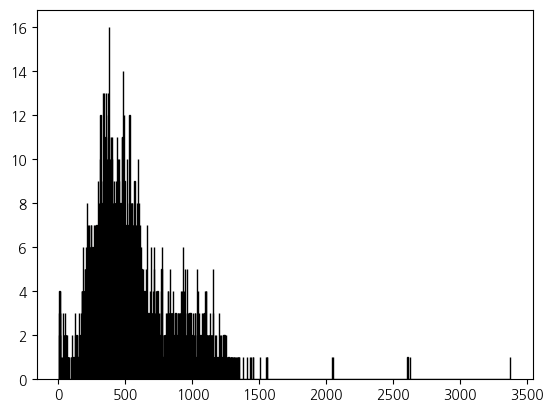

In [6]:
import matplotlib.pyplot as plt

plt.hist(len_list, bins=range(min(len_list), max(len_list) + 1), edgecolor='black')